In [1]:
import os
os.listdir('../regularization/')

['.ipynb_checkpoints',
 'additional_resources',
 'data',
 'readme.md',
 'regularization.pdf',
 'regularization_code.ipynb']

In [2]:
%pylab inline
#% config InlineBackend.figure_format = 'svg'

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


## Regularized Linear Regression Applied to the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), www.amstat.org/publications/jse/v19n3/decock.pdf



In this notebook, we will build some linear regression models to predict housing prices from this data.  We will split our data into training, validation, and test sets, build various (regularized) models on the training/validation data and compare their results on the test set. We will examine metrics such as *r-squared* and *mean absolute error*.

**Notebook Contents**

> 1. Simple EDA and dataset review
> 2. Exploring the behavior of LASSO vs. Ridge regularization
> 3. Standard-scaling features (a must for regularization!)
> 4. Tuning regularization strength via validation
> 5. Automated regularization strength tuning via cross-validation
> 6. _Bonus_: Using the LARS path to study feature importance 

## 1. Simple EDA and Dataset Review

#### Load the Data, Examine and Explore

In [3]:
## Load in the Ames Housing Data
datafile = "data/Ames_Housing_Data.tsv"
df=pd.read_csv(datafile, sep='\t')

In [4]:
## Examine the columns, look at missing data
df.info()

# Missing data (lower numbers)
# object dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [5]:
# This is recommended by the data set author to remove a few outliers

df = df.loc[df['Gr Liv Area'] <= 4000,:]
df.shape

(2925, 82)

There are a *lot* of variables, many of which have a lot of missing values.  Let's pick out just a few columns and start building models using that.

In [6]:
smaller_df= df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars','SalePrice']]

In [7]:
smaller_df.describe()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,SalePrice
count,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2924.000000,2925.000000
mean,10103.583590,6.088205,5.563761,1971.302906,1984.234188,1493.978803,1.564786,2.853675,0.596923,1.765048,180411.574701
std,7781.999124,1.402953,1.112262,30.242474,20.861774,486.273646,0.551386,0.827737,0.645349,0.759834,78554.857286
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,0.000000,0.000000,12789.000000
25%,7438.000000,5.000000,5.000000,1954.000000,1965.000000,1126.000000,1.000000,2.000000,0.000000,1.000000,129500.000000
50%,9428.000000,6.000000,5.000000,1973.000000,1993.000000,1441.000000,2.000000,3.000000,1.000000,2.000000,160000.000000
75%,11515.000000,7.000000,6.000000,2001.000000,2004.000000,1740.000000,2.000000,3.000000,1.000000,2.000000,213500.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,3820.000000,4.000000,8.000000,4.000000,5.000000,625000.000000


In [8]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2924 non-null float64
SalePrice         2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


In [9]:
# There appears to be one NA in Garage Cars - fill with 0
smaller_df = smaller_df.fillna(0)

In [10]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2925 non-null float64
SalePrice         2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


Now that we have a nice, filtered dataset, let's generate visuals to better understand the target and feature-target relationships: pairplot is great for this!

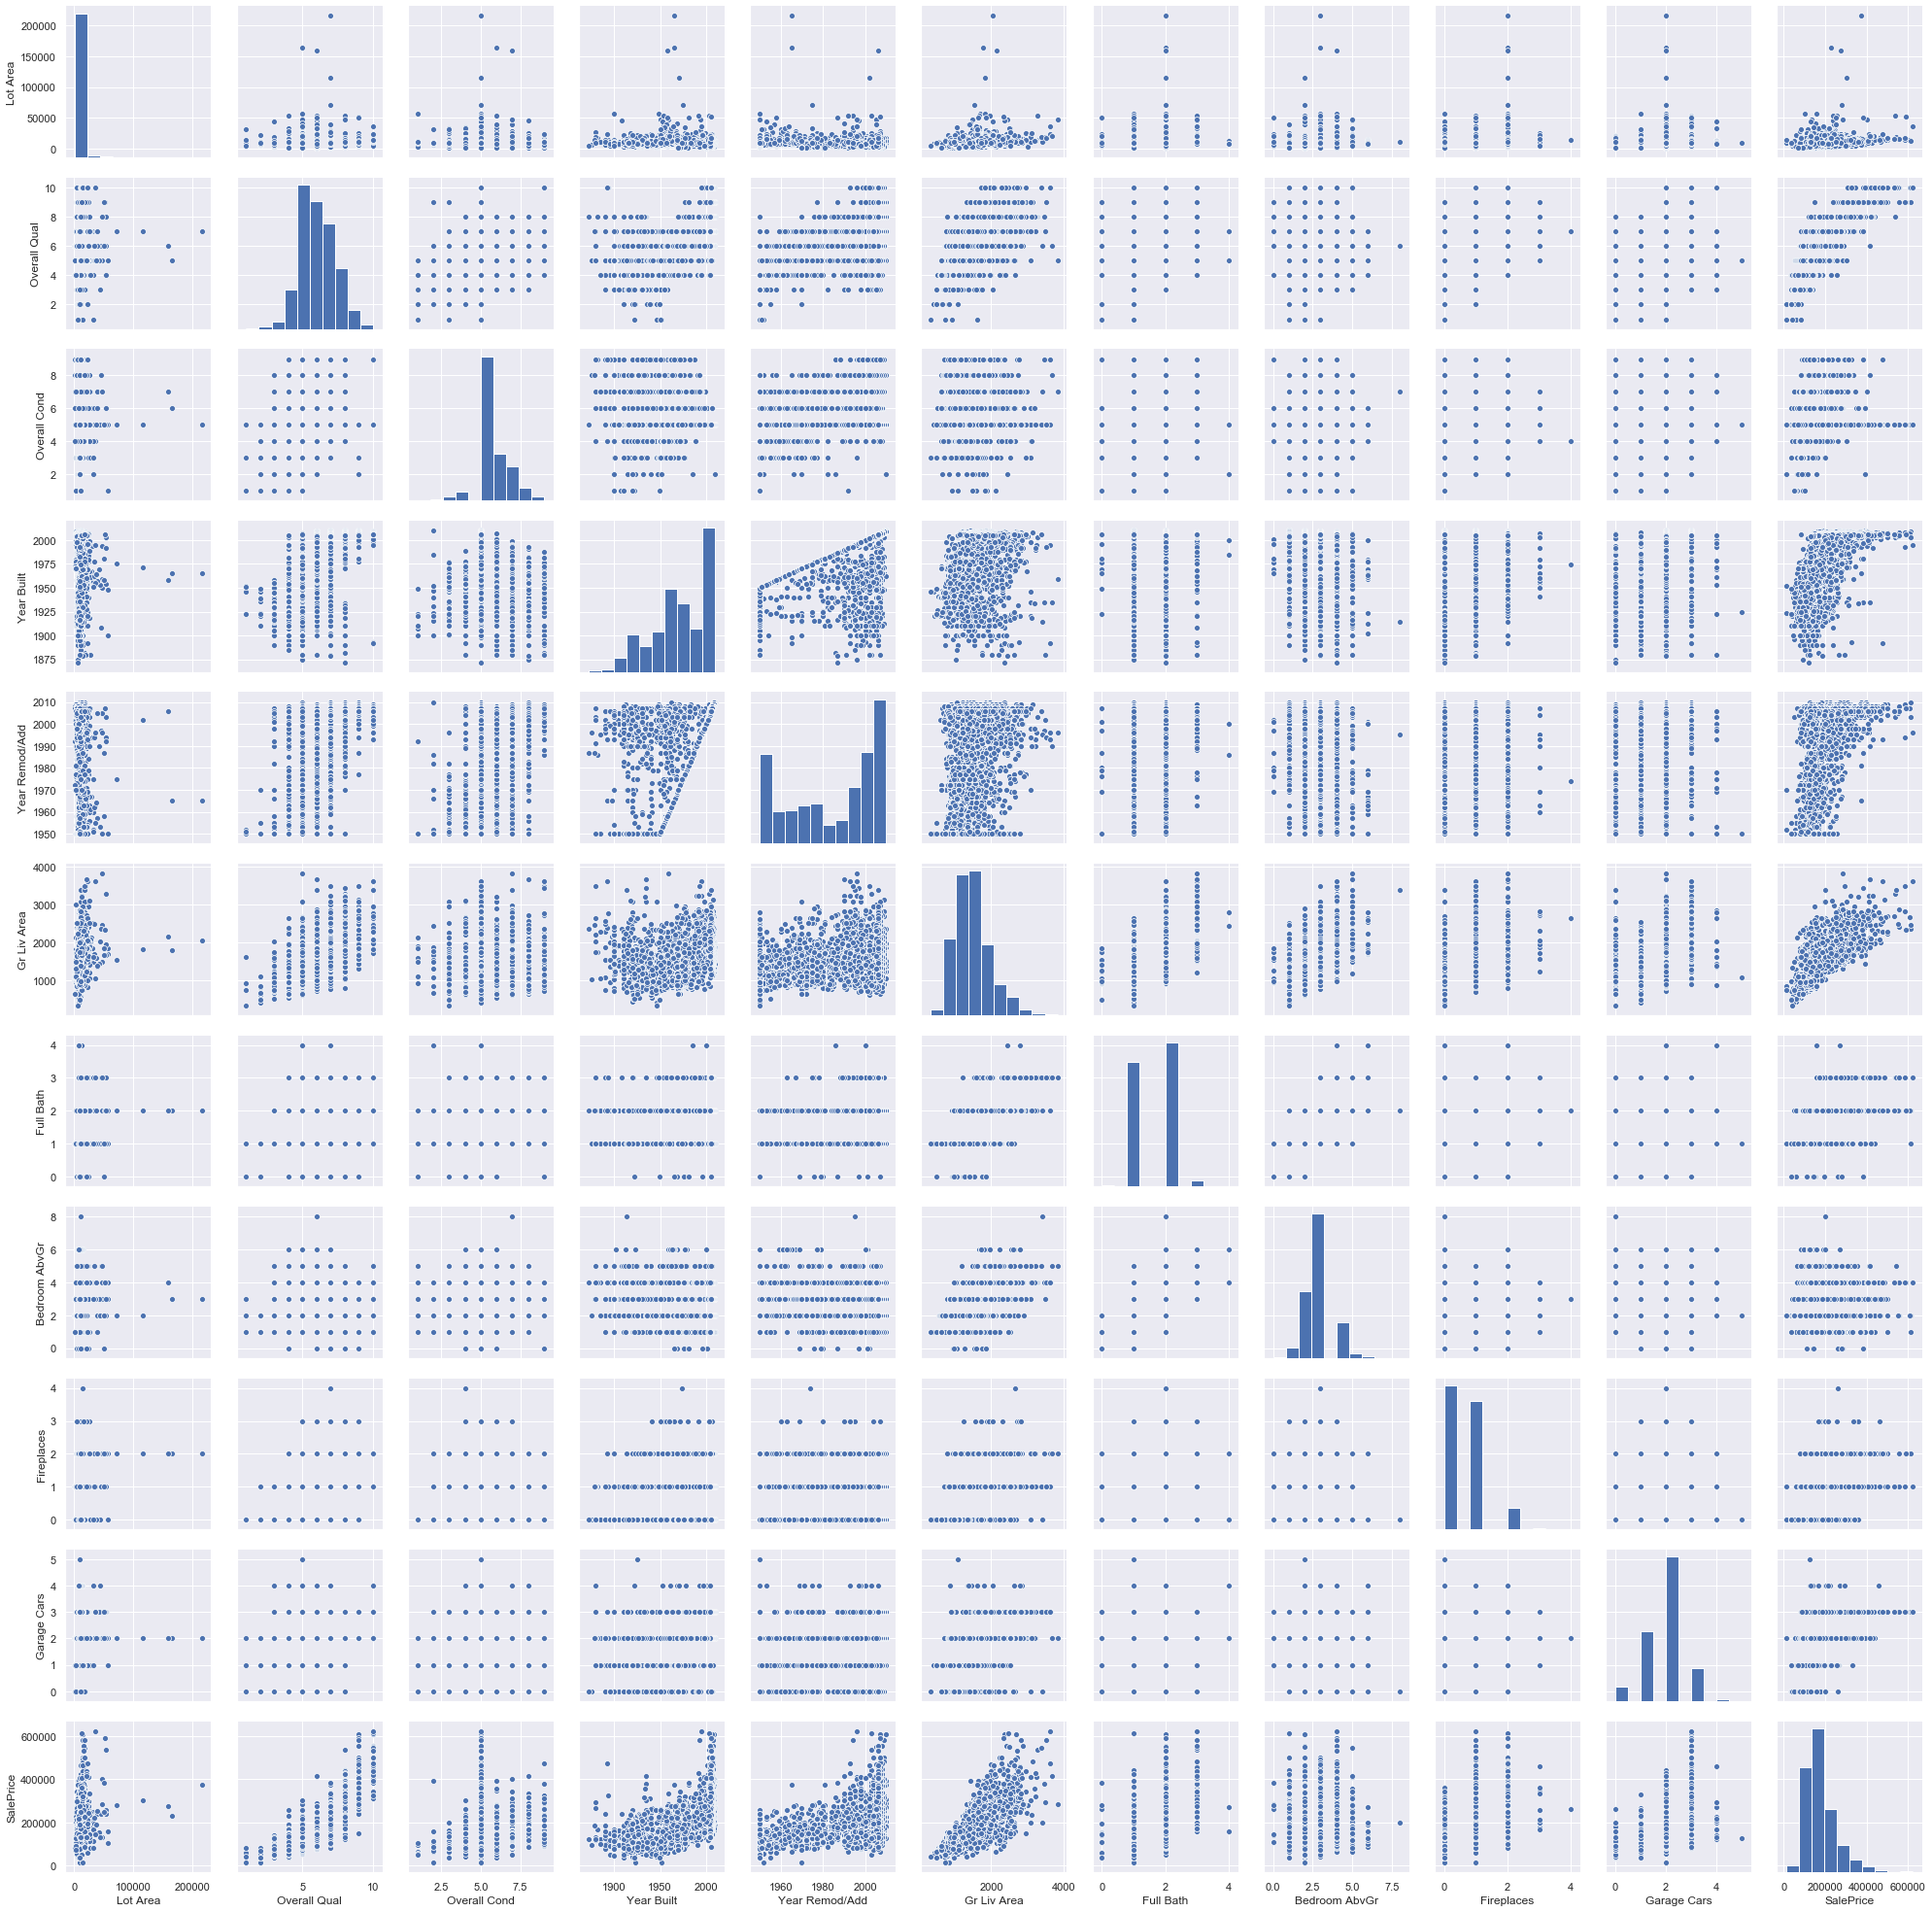

In [11]:
sns.pairplot(smaller_df)

---
**Data Exploration Exercises**: 

1. What do these plots tell us about the distribution of the target?   

2. What do these plots tell us about the relationship between the features and the target? Do you think that linear regression is well-suited to this problem? Do any feature transformations come to mind?

3. What do these plots tell us about the relationship between various pairs of features? Do you think there may be any problems here? 

---

#### Setting up for modeling:

In [12]:
#Separate our features from our target

X = smaller_df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars']]

y = smaller_df['SalePrice']

# create overall quality squared term, which we expect to 
# help based on the relationship we see in the pair plot

X['OQ2'] = X['Overall Qual'] ** 2  
# We can square our overall quality. Because by squaring will make it more linear

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2925 non-null float64
OQ2               2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 354.2 KB


In [14]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [15]:
X_train.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Bedroom AbvGr',
       'Fireplaces', 'Garage Cars', 'OQ2'],
      dtype='object')

In [16]:
X_train.shape  # 80%

(1755, 11)

In [17]:
X_val.shape  # 20%

(585, 11)

In [18]:
X_test.shape  # 20%

(585, 11)

## 2. Exploring the Behavior of LASSO vs. Ridge Regularization

We have been playing around with adding in or removing variables (or transformations of variables), and then seeing if the model improves.  However, this can be a tedious process.

Regularized Linear Regression tries to circumvent this by changing the *cost function*.  In "vanilla" linear regression, the coefficients are chosen purely to minimize the Sum of Squared Errors.  In Regularized Linear Regression, there is an additional component of the cost function that penalizes the "size" of the coefficients.  

Why penalize a coefficient?  At the simplest level, it forces a variable to be "worth it" in order to have a particularly extreme coefficient or even one that's greater than zero.  The intuition is that it is a "simpler model" to have smaller coefficients (in absolute value) than larger ones - regularization means that the coefficients are constrained to lie within a narrower region, making model coefficients more stable and less extreme.

Regularized Linear Regression introduces a **regularization strength parameter** that says how strongly we want to penalize the coefficients.  At one extreme there is no penalty, and we revert back to "vanilla" Linear Regression.  At the other extreme, the penalty is so onerous that we set all of the coefficients to zero.  In between these two extremes are a continuous set of models.  We will see how to choose the best value with *validation* or *cross-validation*.

There are two main "flavors" of Regularized Linear Regression.  In the **LASSO**, we penalize the sum of the absolute values of the coefficients and in **Ridge Regression** we penalize the sum of the squares of the coefficients. Which one works better depends on the data and the business needs of your model (e.g., strong inclination toward interpretability with small set of variables suggests use of LASSO). 

Let's see some examples.

In [19]:
selected_columns = ['Lot Area', 'Overall Qual', 'Overall Cond', 
                    'Year Built','Year Remod/Add', 'Gr Liv Area', 
                    'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                    'Garage Cars', 'OQ2']

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1755 entries, 2121 to 2872
Data columns (total 11 columns):
Lot Area          1755 non-null int64
Overall Qual      1755 non-null int64
Overall Cond      1755 non-null int64
Year Built        1755 non-null int64
Year Remod/Add    1755 non-null int64
Gr Liv Area       1755 non-null int64
Full Bath         1755 non-null int64
Bedroom AbvGr     1755 non-null int64
Fireplaces        1755 non-null int64
Garage Cars       1755 non-null float64
OQ2               1755 non-null int64
dtypes: float64(1), int64(10)
memory usage: 164.5 KB


In [21]:
lasso_model = Lasso(alpha = 1000000) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=1000000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
list(zip(selected_columns, lasso_model.coef_))

[('Lot Area', 0.9127944081046101),
 ('Overall Qual', 0.0),
 ('Overall Cond', -0.0),
 ('Year Built', 0.0),
 ('Year Remod/Add', 0.0),
 ('Gr Liv Area', 102.96627328121187),
 ('Full Bath', 0.0),
 ('Bedroom AbvGr', -0.0),
 ('Fireplaces', 0.0),
 ('Garage Cars', 0.0),
 ('OQ2', 0.0)]

In [23]:
lasso_model = Lasso(alpha = 10) 
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [24]:
list(zip(selected_columns, lasso_model.coef_))

[('Lot Area', 1.0225206856266311),
 ('Overall Qual', -54555.100984207216),
 ('Overall Cond', 7984.603468547271),
 ('Year Built', 628.9048854434933),
 ('Year Remod/Add', 134.1555260688344),
 ('Gr Liv Area', 61.28416723883994),
 ('Full Bath', -6869.050656088438),
 ('Bedroom AbvGr', -4284.669168970797),
 ('Fireplaces', 8032.141313233496),
 ('Garage Cars', 9414.520377768982),
 ('OQ2', 6051.317314926608)]

Notice how LASSO sets many variables to 0 (with a high enough alpha parameter). This is its ** feature selection ** property. To help remember that LASSO does this and not ridge, look no further than the name: **Least Absolute Shrinkage and Selection Operator** -- the shrinkage part means making the coefficients smaller by penalizing their size in the cost function, and the selection part is zeroing out coefficients. Remember the double SS! 

To highlight a notable difference between LASSO and ridge, we're going to add an additional column that's Lot Area + noise, so that we have two **highly collinear columns**. Then we'll fit a ridge and LASSO model and compare their coefficients.

In [25]:
np.random.seed(6)

X_train_collinear = X_train.loc[:,selected_columns]
X_train_collinear['Lot Area Clone'] = (X_train_collinear['Lot Area'] + 
                                      2500 * np.random.randn(X_train.shape[0]))

X_train_collinear.corr() #notice .95 correlation b/w Lot Area and its "clone"

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,OQ2,Lot Area Clone
Lot Area,1.000000,0.081097,-0.037736,0.017427,0.000597,0.258829,0.111286,0.132810,0.243096,0.174151,0.085420,0.958391
Overall Qual,0.081097,1.000000,-0.112870,0.588271,0.561724,0.558242,0.520523,0.099745,0.388634,0.598281,0.988045,0.080411
Overall Cond,-0.037736,-0.112870,1.000000,-0.362988,0.038403,-0.109594,-0.224751,-0.006568,-0.015056,-0.171561,-0.143081,-0.037056
Year Built,0.017427,0.588271,-0.362988,1.000000,0.605859,0.228172,0.474961,-0.031895,0.169074,0.529899,0.579530,0.018261
Year Remod/Add,0.000597,0.561724,0.038403,0.605859,1.000000,0.320019,0.463173,-0.000673,0.135249,0.427543,0.554131,0.003624
Gr Liv Area,0.258829,0.558242,-0.109594,0.228172,0.320019,1.000000,0.647458,0.561929,0.460890,0.471873,0.556865,0.251994
Full Bath,0.111286,0.520523,-0.224751,0.474961,0.463173,0.647458,1.000000,0.369690,0.229475,0.470856,0.512350,0.116851
Bedroom AbvGr,0.132810,0.099745,-0.006568,-0.031895,-0.000673,0.561929,0.369690,1.000000,0.121211,0.092666,0.075606,0.127771
Fireplaces,0.243096,0.388634,-0.015056,0.169074,0.135249,0.460890,0.229475,0.121211,1.000000,0.300126,0.379624,0.233069
Garage Cars,0.174151,0.598281,-0.171561,0.529899,0.427543,0.471873,0.470856,0.092666,0.300126,1.000000,0.601796,0.168621


As a quick aside, let's understand what happens with p-values when there is a lot of collinearity! We are much less sure about our relationships being meaningful. In this case the model does detect the right variable as having a significant relationship, but this need not be the case in general.

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y_train, sm.add_constant(X_train_collinear))
results = model.fit()

results.summary()

C:\Users\User\.conda\envs\metis\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     928.3
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:03:44   Log-Likelihood:                -20465.
No. Observations:                1755   AIC:                         4.096e+04
Df Residuals:                    1742   BIC:                         4.103e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.375e+06   8.71e+04    -15.784      0.000   -1.55e+06    -1.2e+06
Lot Area           1.0480      0.295      3.554      0.000       0.470       1.626
Overall Qual   -5.483e+04   3341.216    -16.410      0.000   -6.14e+04   -4.83e+04
Overall Cond    8006.6551    738.304     10.845      0.000    6558.600    9454.710
Year Built       629.6827     37.155     16.947      0.000     556.809     702.556
Year Remod/Add   134.1557     47.148      2.845      0.004      41.683     226.628
Gr Liv Area       61.3160      2.640     23.222      0.000      56.137      66.495
Full Bath      -6918.3737   1836.548     -3.767      0.000   -1.05e+04   -3316.303
Bedroom AbvGr  -4287.1655   1117.759     -3.836      0.000   -6479.456   -2094.875
Fireplaces      8063.8450   1233.604      6.537      0.000    5644.344    1.05e+04
Garage Cars     9443.8361   1223.927      7.716      0.000    7043.316    1.18e+04
OQ2             6071.5277    264.306     22.972      0.000    5553.136    6589.919
Lot Area Clone    -0.0263      0.279     -0.094      0.925      -0.574       0.521
==============================================================================
Omnibus:                      259.173   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3018.036
Skew:                           0.260   Prob(JB):                         0.00
Kurtosis:                       9.403   Cond. No.                     2.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now let's compare and contrast Ridge vs. Lasso

In [27]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_ridge.coef_))

# You can see that "lot area" and "lot area clone" get the same coef

[('Lot Area', 0.23456806824868837),
 ('Overall Qual', 0.00014999853048195728),
 ('Overall Cond', -1.6277896116557217e-05),
 ('Year Built', 0.0023391582403281563),
 ('Year Remod/Add', 0.0015461523211213108),
 ('Gr Liv Area', 0.045465320948531916),
 ('Full Bath', 4.119945288825558e-05),
 ('Bedroom AbvGr', 1.9196695047652727e-05),
 ('Fireplaces', 4.010019534658269e-05),
 ('Garage Cars', 6.512458130664569e-05),
 ('OQ2', 0.0019390875325796598),
 ('Lot Area Clone', 0.23755021970497325)]

**Ridge** smoothed out all of the coefficients, **bringing them closer to 0 but not discarding any of them**. Also, it gave **roughly equal weight to the two highly collinear features**.

In [28]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_lasso.coef_))

# In lasso, we can see that "lot area" and "lot area clone" as to which one is useless or not
# This helps with feature selection.

[('Lot Area', 1.2049095934791583),
 ('Overall Qual', 0.0),
 ('Overall Cond', 0.0),
 ('Year Built', 498.76818440491115),
 ('Year Remod/Add', 82.25783922955299),
 ('Gr Liv Area', 62.85160719675214),
 ('Full Bath', -0.0),
 ('Bedroom AbvGr', -0.0),
 ('Fireplaces', 0.0),
 ('Garage Cars', 0.0),
 ('OQ2', 1724.5628429010624),
 ('Lot Area Clone', -0.0)]

Meanwhile, **Lasso zeroed out most of the coefficients**, and **dropped the noisy collinear clone**, performing feature selection to keep the features we really wanted. 

What are the Pros/Cons of either behavior?

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful

**Ridge**:
* _Pro_: **great for smoothly handling multicollinearity**, very nice when working with sparse features 
* _Con_: will never fully discard features

As always, you have to validate to choose between the two. 
  
If the mapping from features to target truly depends on only a few key features, LASSO should outperform. 
> When you want to want to do feature selection, you will use LASSO or ELASTIC NET
  
If instead the target actually depends on many features (even if only a little dependent), Ridge should work better.  

In [29]:
#Back to the original LASSO model: diagnostics

In [30]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

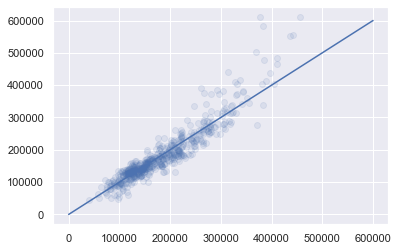

In [32]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

In [34]:
#r-squared
r2_score(y_test, test_set_pred)

0.8669500820335845

In [35]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


mae(y_test, test_set_pred)


# MSE you penalize your errors. Because you square the errors a lot
# MAE is just absolute


# Why is it better to use MAE as compared to MSE?
# 1: pro -> Using same unit as your y
# MSE is not in the same unit as your y. For eg. What is the meaning if your price ** 2?

20248.616804946512

## 3. Standard-scaling Features (a must for regularization!)

One issue with Regularized Linear Regression is that the "size" of a coefficient may be more reflective of the units or scale of the associated variable than the actual power of the relationship.  For example, if a distance is measured in millimeters it will have a larger coefficient than if it is measured in miles.  For this reason, best practice is to "standardize" the variables prior to running a regularized regression.  Standardizing means subtracting off each feature column's mean and then dividing by its standard deviation so that the resulting variable has mean 0 and standard deviation 1. This ensures that the variables are penalized fairly with respect to one another.

We demonstrate how to do this below.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [37]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X_train.values)
X_tr

array([[ 0.13576249, -0.04866612, -0.51602588, ..., -0.90515948,
         0.3187173 , -0.15770089],
       [-0.01884634, -0.76638916,  1.30249906, ..., -0.90515948,
        -1.01306572, -0.78632274],
       [-0.50271473, -0.76638916,  0.39323659, ...,  0.62819466,
        -1.01306572, -0.78632274],
       ...,
       [ 0.11285747,  1.38677996, -0.51602588, ...,  0.62819466,
         1.65050033,  1.44242747],
       [-0.64213654, -2.20183524, -2.33455083, ..., -0.90515948,
        -2.34484874, -1.7006818 ],
       [-0.35731769, -0.76638916,  0.39323659, ..., -0.90515948,
        -1.01306572, -0.78632274]])

In [40]:
## Apply the scaler to the test set

X_te = std.transform(X_test.values)
X_te

array([[-0.97724682, -0.04866612,  0.39323659, ..., -0.90515948,
         0.3187173 , -0.15770089],
       [ 1.27877238,  2.104503  , -0.51602588, ...,  2.16154879,
         1.65050033,  2.41393397],
       [-0.25312478,  0.66905692,  0.39323659, ..., -0.90515948,
         0.3187173 ,  0.58521585],
       ...,
       [-0.55698965, -0.04866612,  2.21176153, ..., -0.90515948,
        -1.01306572, -0.15770089],
       [ 0.59809518,  1.38677996, -0.51602588, ...,  2.16154879,
         0.3187173 ,  1.44242747],
       [-0.11519678,  2.104503  , -0.51602588, ...,  0.62819466,
         1.65050033,  2.41393397]])

In [41]:
## Note that even though we put a Pandas Dataframe into the scalar, what comes out is a numpy array
## In general, sklearn works on numpy.  It will accept pandas objects by trying to coerce them to numpy arrays
## But it will not usually output pandas objects

type(X_train), type(X_tr)

(pandas.core.frame.DataFrame, numpy.ndarray)

(array([ 10.,   9.,  49., 150.,  91., 160., 325., 257., 158., 546.]),
 array([-3.26826014, -2.81248774, -2.35671534, -1.90094295, -1.44517055,
        -0.98939815, -0.53362575, -0.07785336,  0.37791904,  0.83369144,
         1.28946384]),
 <a list of 10 Patch objects>)

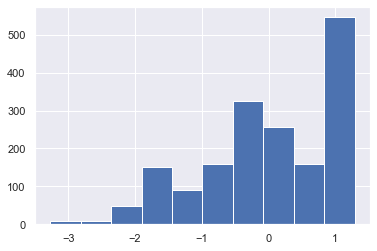

In [42]:
## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

Now that we have appropriately scaled our variables, we can apply the LASSO as before.

What we did before was technically not good practice since the variables were on different scales.  Certain variables would be (unfairly) penalized more than others.

In [43]:
## Fit a LASSO model on the standardized data

lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_tr,y_train)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [44]:
## Note that now we can meaningful compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

list(zip(X_train.columns, lasso_model.coef_))

[('Lot Area', 1031.69852056626),
 ('Overall Qual', 0.0),
 ('Overall Cond', 0.0),
 ('Year Built', 5783.8633555037695),
 ('Year Remod/Add', 247.66794494806524),
 ('Gr Liv Area', 19918.9224089355),
 ('Full Bath', 0.0),
 ('Bedroom AbvGr', -0.0),
 ('Fireplaces', 406.7505456449257),
 ('Garage Cars', 6202.751021066891),
 ('OQ2', 34929.43390855041)]

## 4. Tuning Regularization Strength via Validation

Here we will attempt to find the "best" value of the regularization strength alpha for this feature and target set and the LASSO model. We'll use simple validation (single train/valid split) as our model selection method.

We will first decide on a vector of "candidate" alpha values.  Then, for each candidate value, we run the following steps:

> 1. Fit a LASSO model on the training data
> 2. Using the newly trained model, make predictions on the validation data
> 3. Run evaluation metrics on validation

Then we plot how the errors change for the different values of alpha, and see where alpha minimizes our error metric on the validation data. This value of alpha is the one we would select for our final model.

In [45]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

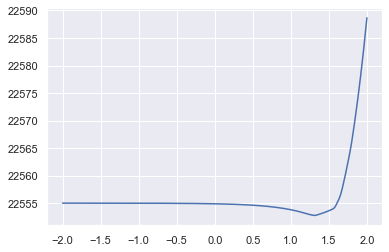

In [62]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

# This is the MAE vs value of lambda (as defined in alphalist)
# Don't forget that there is a log10 applied here, so we need to scale it back!

In [47]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

22552.78314677297

In [63]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

20.72921779595372

---
**Regularization Tuning Exercise**: 

Repeat the model selection workflow above (simple validation), but using a ridge model instead of a LASSO model. Based on the evidence you gather, do you think that a ridge or LASSO model has better predictive power on this dataset?

---

## 5. Automated Regularization Strength Tuning via Cross-validation 

### Using LassoCV to find the best alpha via Cross-Validation
In the previous section, we found the best alpha value by comparing the performance on a single validation set.  An even better, though more computationally intensive method, is to do a full cross-validation when comparing the different alphas. Fortunately, the `LassoCV` in sklearn handles this "under the hood". You pass the `LassoCV` the list of alphas and the number of folds to use for Cross-Validation.  

It will do the following for each candidate value of alpha:

> 1. Run cross-validation and score the result
> 2. Find the value of alpha that gave the best CV score
> 3. Fit a final model on all the data using the best value of alpha it just found

Then you can use the `predict` method of the model just as with all of our previous models

In [49]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [57]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

LassoCV does 2 things for you. It trains your model, and it also chooses the best lambda/alpha for you.  
  
But of course, you have to give it a list of lambdas to try

## This is doing all 3 for you. Doing fitting, finding best lambda and CV for you

In [51]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)  

lasso_model = LassoCV(alphas = alphavec, cv=5)  # If you want to use Ridge, use RidgeCV
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [52]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

16.446761779946645

In [53]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('Lot Area', 8204.75076600052),
 ('Overall Qual', -74783.35580661903),
 ('Overall Cond', 8713.354525056795),
 ('Year Built', 18955.10666583034),
 ('Year Remod/Add', 2806.633933790032),
 ('Gr Liv Area', 29846.14817059467),
 ('Full Bath', -3803.601562045151),
 ('Bedroom AbvGr', -3484.2263171407158),
 ('Fireplaces', 5234.335509391658),
 ('Garage Cars', 7095.431668970783),
 ('OQ2', 104699.37299968622)]

In [54]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [55]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

20240.3800379069

In [56]:
r2_score(y_test, test_set_pred)

0.8667843957521529

---
**Regularization Tuning with CV Exercise**: 

Repeat the model selection workflow above (CV), but using the RidgeCV model instead of the LassoCV model. Based on the evidence you gather, do you think that a ridge or LASSO model has better predictive power on this dataset?

---

## 6. _Bonus_: Using the LARS Path to Study Feature Importance 

This is a tool used to visualize *all* of the LASSO models across a range of different alpha values.  At the far left is the value of alpha where the penalty on coefficients is *so* onerous, that it just sets all of the coefficients to zero.  At the far right is when there is no penalty, and corresponds to the values of the coefficients that you would get from a "vanilla" linear regression.

So each vertical slice corresponds to the coefficients you would get at a particular setting of alpha.  The black dotted lines indicate where a new variable "enters" the model (that is, its coefficient changes from 0 to non-zero).

This is a good way to see which variables are most influential and how their strengths change as you change the value of alpha. Intuitively, the features that enter the model (nonzero coefficients) earliest in the path are the ones that the model treats as most essential, that it doesn't want to live without.

In [57]:
from sklearn.linear_model import lars_path

In [58]:
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [59]:
X_tr = std.transform(X_train.values)

In [60]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


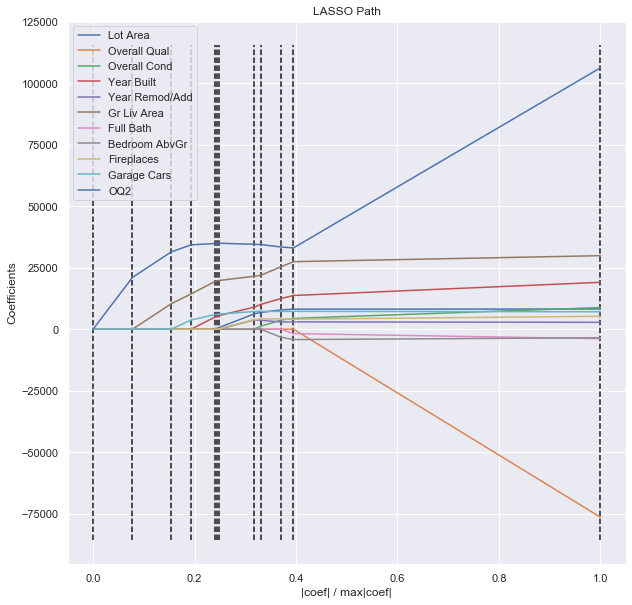

In [61]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()